In [2]:
from rbm_torch.utils import data_prep as dp
from rbm_torch.analysis import analysis_methods as am

In [3]:
thr_df = am.fetch_data(["r5", "r6", "r7", "r8"], dir="/mnt/D1/process_thrombin_aptamers/", threads=6, molecule="dna", normalize_counts=True, normalization_denominator=100000)

Process Time 1.8942933082580566
Process Time 0.4419431686401367
Process Time 0.4178619384765625
Process Time 0.3263742923736572


In [4]:
def enrichment_averge(df, round_names, min_diff=1, max_diff=None, diff_weights=None, round_weights=None):
    round_number = len(round_names)

    if max_diff is None:
        max_diff = round_number-1

    if diff_weights is None:
        diff_weights = [1. for x in range(min_diff, max_diff+1)]

    if round_weights is None:
        round_weights = [1. for x in range(len(round_names))]

    # first let's remove all the nan values in the dataframe, set nan values as the minimum normalized count for each round
    for r in round_names:
        df[r] = df[r].fillna(df[r].min())

    # Get fold value for round differences
    fold_keys = {diff: [] for diff in range(min_diff, max_diff+1)}
    for i in range(round_number):
        for j in range(round_number):
            if i >= j or j - i < min_diff or j - i > max_diff:
                continue
            fold_column_name = f"fold_{round_names[j]}v{round_names[i]}"
            fold_keys[j-i].append(fold_column_name)
            # fold_diffs.append(j-i)
            df[fold_column_name] = df[round_names[j]]/df[round_names[i]] * (round_weights[j] + round_weights[i])

    diff_keys = []
    for i in range(min_diff, max_diff+1):
        diff_avg_key = f"fold_diff{i}_avg"
        df[diff_avg_key] = df[fold_keys[i]].sum(axis=1).div(len(fold_keys[i])).mul(diff_weights[i-1])
        diff_keys.append(diff_avg_key)

    df["Final_Fold_Avg"] = df[diff_keys].sum(axis=1).div(len(diff_keys))

    return df

In [7]:
thr_df.head()

,sequence,copy_num,round,assignment
0,GGGGGTGGGGGGGTGGAGGA,15.191281,r5,N/A
1,GGGGATGGGGGGGTGGAGGA,14.406492,r5,N/A
2,CGGGTTGGGGGGGTGGAGAG,13.005082,r5,N/A
3,GTAGGATGGGTAGGGTGGTC,11.883954,r5,N/A
4,GGGGGGTGGGGGGGGTGGTC,11.771842,r5,N/A


In [8]:
thr_ct = dp.copynum_topology_faster(thr_df, ["r5", "r6", "r7", "r8"], threads_per_task=3)

Process Time 3268.212295770645


In [9]:
thr_ct.to_csv("./thrombin/thr_ct.csv", index=False)

In [10]:
thr_final = enrichment_averge(thr_ct, ["r5", "r6", "r7", "r8"], min_diff=1, max_diff=None, diff_weights=[0.95, 1.0, 1.0], round_weights=[0.95, 0.97, 1.0, 1.02])

In [11]:
thr_final.head()

,sequence,r5,r6,r7,r8,fold_r6vr5,fold_r7vr5,fold_r8vr5,fold_r7vr6,fold_r8vr6,fold_r8vr7,fold_diff1_avg,fold_diff2_avg,fold_diff3_avg,Final_Fold_Avg
0,AGGGATGGCAGCTGGTTGGG,0.112113,0.135789,0.133169,0.068925,2.325472,2.316234,1.211114,1.931987,1.010094,1.045496,1.679269,1.663164,1.211114,1.517849
1,ACAGGGTGGCTAGGGTGGGA,0.112113,0.067895,0.066584,0.206774,1.162736,1.158117,3.633342,1.931987,6.060567,6.272976,2.966438,3.609342,3.633342,3.403041
2,TATGGGTGGGTAGGTTGGAC,0.056056,0.203684,0.066584,0.068925,6.976416,2.316234,2.422228,0.643996,0.673396,2.090992,3.075278,1.494815,2.422228,2.330774
3,TTGTGGTTGGGGTGGATGGT,0.112113,0.067895,0.466091,0.206774,1.162736,8.106818,3.633342,13.523906,6.060567,0.896139,4.934547,7.083692,3.633342,5.217194
4,GGCGTGGGGGGTTGGGGAGG,0.224226,0.543156,0.466091,0.206774,4.650944,4.053409,1.816671,1.690488,0.757571,0.896139,2.291898,2.405490,1.816671,2.171353


In [12]:
thr_final.sort_values("Final_Fold_Avg", ascending=False, inplace=True)
thr_final.head()

,sequence,r5,r6,r7,r8,fold_r6vr5,fold_r7vr5,fold_r8vr5,fold_r7vr6,fold_r8vr6,fold_r8vr7,fold_diff1_avg,fold_diff2_avg,fold_diff3_avg,Final_Fold_Avg
111634,AGGGATGATGCGTGGTAGGC,1.569579,40.397265,338.715133,291.068344,49.416279,420.810016,365.323877,16.517673,14.338248,1.735848,21.428770,217.574132,365.323877,201.442260
158469,AGGGATGATGTGTGGTAGGC,3.867891,101.638160,813.595481,698.343468,50.452631,410.174763,355.681354,15.769501,13.673049,1.733852,21.519395,211.923906,355.681354,196.374885
211578,AGGGTTGATGCGTGGTAGGC,0.672677,17.313113,112.860655,95.046945,49.416279,327.167999,278.354360,12.842028,10.924865,1.701167,20.253834,169.046432,278.354360,155.884875
178184,AGGGTTGATGTGTGGTAGGC,2.130143,54.655123,359.156561,299.752837,49.263288,328.783268,277.217612,12.945510,10.914039,1.685896,20.233320,169.848653,277.217612,155.766528
131419,AGGGTAGGCGTGGATGATGC,2.298312,56.624065,379.797743,325.254917,47.303503,322.238941,278.792527,13.213491,11.430781,1.729907,19.711519,166.834861,278.792527,155.112969


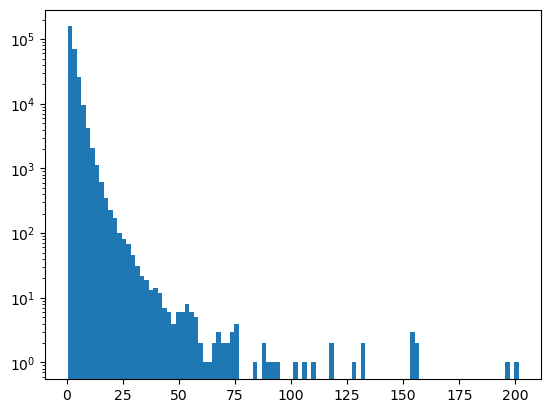

In [13]:
dp.quick_hist(thr_final["Final_Fold_Avg"].to_numpy())

In [14]:
thr_final.index.__len__()

270881

In [16]:
thr_final["fitness_value"] = dp.scale_values_np(dp.log_scale(thr_final["Final_Fold_Avg"].to_list(), base=1.0), min=0.01, max=1.0).squeeze(1).tolist()

In [17]:
thr_final.head()

,sequence,r5,r6,r7,r8,fold_r6vr5,fold_r7vr5,fold_r8vr5,fold_r7vr6,fold_r8vr6,fold_r8vr7,fold_diff1_avg,fold_diff2_avg,fold_diff3_avg,Final_Fold_Avg,fitness_value
111634,AGGGATGATGCGTGGTAGGC,1.569579,40.397265,338.715133,291.068344,49.416279,420.810016,365.323877,16.517673,14.338248,1.735848,21.428770,217.574132,365.323877,201.442260,1.000000
158469,AGGGATGATGTGTGGTAGGC,3.867891,101.638160,813.595481,698.343468,50.452631,410.174763,355.681354,15.769501,13.673049,1.733852,21.519395,211.923906,355.681354,196.374885,0.994993
211578,AGGGTTGATGCGTGGTAGGC,0.672677,17.313113,112.860655,95.046945,49.416279,327.167999,278.354360,12.842028,10.924865,1.701167,20.253834,169.046432,278.354360,155.884875,0.949648
178184,AGGGTTGATGTGTGGTAGGC,2.130143,54.655123,359.156561,299.752837,49.263288,328.783268,277.217612,12.945510,10.914039,1.685896,20.233320,169.848653,277.217612,155.766528,0.949499
131419,AGGGTAGGCGTGGATGATGC,2.298312,56.624065,379.797743,325.254917,47.303503,322.238941,278.792527,13.213491,11.430781,1.729907,19.711519,166.834861,278.792527,155.112969,0.948674


In [18]:
dp.dataframe_to_fasta(thr_final, "./thrombin/enriched.fasta", count_key="fitness_value")

In [21]:
r5_data = thr_df[thr_df["round"] == "r5"]

r5_only = exclusive_rows(r5_data, thr_final, "sequence")

In [23]:
r5_sample = r5_only.sample(350000)

In [25]:
r5_enriched_dists = prune_similar_sequences_df(r5_sample, thr_final, molecule="dna", return_min_distances = True )

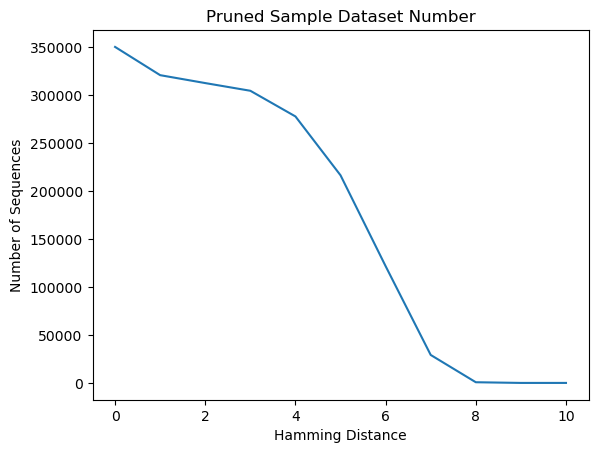

In [26]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 1)
hamming_dists = np.arange(0, 11, 1).tolist()
number_of_seqs =[sum(i > d for i in r5_enriched_dists) for d in hamming_dists]
axs.plot(hamming_dists, number_of_seqs)
axs.set_xlabel("Hamming Distance")
axs.set_ylabel("Number of Sequences")
axs.set_title("Pruned Sample Dataset Number")
plt.show()

In [27]:
import numpy as np
from copy import copy
r5_keep = (np.asarray(r5_enriched_dists) > 1)

background = copy(r5_sample[r5_keep].iloc[:270000])
background["fitness_value"] = dp.scale_values_np(background["copy_num"].to_numpy(), min=0.001, max=0.009).squeeze(1).tolist()

dp.dataframe_to_fasta(background, "./thrombin/background.fasta", count_key="fitness_value")

In [24]:
from copy import copy
def exclusive_rows(key_pd, query_pd, col_val):
    """returns rows in key pd that are not in query pd"""
    df_all = key_pd.merge(query_pd.drop_duplicates(), on=col_val, how='left', indicator=True)
    df_subset = copy(df_all[df_all['_merge'] == 'left_only'])
    return df_subset.drop("_merge", axis=1)

from rbm_torch.utils.seq_utils import seq_to_cat
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics.pairwise import pairwise_distances_chunked
import numpy as np


def prune_similar_sequences_df(df1, df2, hamming_threshold=0, molecule="protein", return_min_distances=False):
    """generate subset of sequences in df1 that are at least x mutations away from all sequences in df2"""
    df1.reset_index(drop=True, inplace=True)
    df1_seqs = df1["sequence"].tolist()
    df1_index = df1.index.tolist()

    df1_cat = seq_to_cat(df1_seqs, molecule=molecule)
    X = df1_cat.numpy().astype(np.int8)

    df2.reset_index(drop=True, inplace=True)
    df2_seqs = df2["sequence"].tolist()
    df2_index = df2.index.tolist()

    df2_cat = seq_to_cat(df2_seqs, molecule=molecule)
    Y = df2_cat.numpy().astype(np.int8)

    seq_len = len(df1_seqs[0])

    def reduce_func(D_chunk, start):
        # print(D_chunk)
        return np.asarray(D_chunk).min(1).tolist()

    min_distances_chunked = pairwise_distances_chunked(X, Y, reduce_func=reduce_func, metric="hamming")

    mdists = []
    for n1 in min_distances_chunked:
        mdists += n1

    if return_min_distances:
        return [x * seq_len for x in mdists]
    else:
        keep = np.asarray(mdists) * seq_len > hamming_threshold

        dataframe = df1.iloc[keep, :]

        print(f"Kept {dataframe.index.__len__()} of {df1.index.__len__()} in df1")

        dataframe.reset_index(drop=True, inplace=True)
        return dataframe